# MMDS Course Project: System Detecting Bots

## Make sure the notebook is connected to http server where jupyter/pyspark-notebook docker container runs
1. Download the docker image
> docker pull jupyter/pyspark-notebook
2. Start the container by mounting the project folder "./mount" to default folder within the container "/home/jovyan/work"
> docker run -it --rm -p 8888:8888 -v ./mount:/home/jovyan/work jupyter/pyspark-notebook
3. Add the localhost:8888 to the jupyter kernels and connect the notebook

In [14]:
# move to the mounted directory inside the container
!cd /home/jovyan/work

## Install the necessary modules inside on the docker container

In [15]:
!pip install numpy==1.23.5 pandas==1.5.3 scikit-learn==1.2.2 seaborn==0.12.2 ipykernel==6.25.2 sseclient==0.0.27 tqdm==4.65.0 yellowbrick==1.4

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 3.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 3.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for sseclient: filename=sseclient-0.0.27-py3-none-any.whl size=5564 sha256=c3a4b518056a8a94847b82dac016a89a42c55c3c8a73e307a1c989ff005aaeff
  Stored in directory: /home/jovyan/.cache/pip/wheels/7c/54/eb/a223b1599728ecaf0528281c17c96c503aa7d18a752a4e4e3a
Successfully built sseclient
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.5
    Uninstalling tqdm-4.66.5:
      Successfully uninstalled tqdm-4.66.5
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.model_selection import FeatureImportances

import argparse
import json
from csv import DictWriter
from sseclient import SSEClient as EventSource
from tqdm import tqdm
from datetime import datetime, timedelta
from typing import Generator, Dict
from pandas import DataFrame, Series

## Sampling from Wikimedia Recent Changes stream

In [17]:
past_datetime = datetime.now() - timedelta(weeks=2)
since_timestamp = int(past_datetime.timestamp() * 1000)
URL = f'https://stream.wikimedia.org/v2/stream/recentchange?since={since_timestamp}'
SAMPLE_FILE = f"./sampled_events_id.csv"

### Definitions

In [18]:
def is_relevant_event(event: Dict, wiki='enwiki') -> bool:
    """
    Checks if the event is relevant for sampling, i.e., it is an edit made by a bot on the specified wiki topic.

    Args:
    - event (dict): The event data.
    - wiki (str): The wiki to filter for (default is 'enwiki').

    Returns:
    - bool: True if the event is an edit by a bot in the specified wiki, False otherwise.
    """
    return  event.get('type') != None and event.get('type') == 'edit' and event.get('wiki') == wiki


def should_sample_event(event: Dict, sample_by: str, threshold: float = 0.2) -> bool:
    """
    Determines if an event should be sampled based on threshold.

    Args:
    - event (dict): The event data containing fields for sampling.
    - sample_by (str): The event field we sample by.
    - threshold (float): Probability threshold for sampling (default: 0.2 for 20%).

    Returns:
    - bool: True if the event should be sampled, False otherwise.
    """
    sample_by_value = event.get(sample_by, "")
    if sample_by_value == "":
        return False

    time_hash_val = abs(hash(sample_by_value)) % 100 / 100
    return time_hash_val < threshold


def write_event_to_csv(writer: DictWriter, event):
    """
    Writes a single event to the CSV file.

    Args:
    - writer (csv.DictWriter): The CSV writer object.
    - event (dict): The event data to be written.
    """
    row = {
        'bot': event['bot'],
        'user': event['user'],
        'timestamp': event['timestamp'],
        'namespace': event['namespace'],
        'title': event['title'],
        'comment': event.get('comment', ''),
        'length_old': event['length']['old'],
        'length_new': event['length']['new'],
        'revision_old': event['revision']['old'],
        'revision_new': event['revision']['new'],
    }
    writer.writerow(row)


def subscribe_to_stream(url: str, wiki: str='enwiki') -> Generator[Dict, None, None]:
    """
    Subscribes to the Wikimedia recent changes stream and yields relevant events.

    Args:
    - url (str): The URL of the Wikimedia recent changes stream.
    - wiki (str): The wiki to filter for (default is 'enwiki').

    Yields:
    - dict: A dictionary representing a relevant bot edit event.
    """
    for event in EventSource(url):
        if event.event == 'message':
            try:
                change = json.loads(event.data)
            except ValueError:
                continue

            if is_relevant_event(change, wiki=wiki):
                yield change


def sample_to_csv(events: Generator, output_file: str, sample_by: str, threshold: float=0.2, sample_limit: int=40000):
    """
    Samples events and writes them to a CSV file up to a specified limit.

    Args:
    - events (iterable): An iterable of events to be sampled.
    - output_file (str): The filename for the output CSV file.
    - interval_size (int): The size of the time interval in seconds (60 seconds by default).
    - threshold (float): Probability threshold for sampling (0.2 for 20%).
    - sample_limit (int): The maximum number of samples to collect.
    """
    csv_fields = ['bot', 'user', 'timestamp', 'namespace', 'title', 'comment', 'length_old', 'length_new', 'revision_old', 'revision_new']
    
    with open(output_file, mode='w', newline='', encoding='utf-8') as csv_file:
        writer = DictWriter(csv_file, fieldnames=csv_fields)
        writer.writeheader()

        sample_count = 0
        with tqdm(total=sample_limit, desc=f"Sampling {threshold*100:.0f}%", unit="sample", miniters=1) as prog_bar:
            for event in events:
                if sample_count >= sample_limit:
                    break

                if should_sample_event(event, sample_by, threshold):
                    write_event_to_csv(writer, event)
                    sample_count += 1
                    prog_bar.update(1)

    print(f"Sampling complete. {sample_count} edits written to {output_file}")


### Run Sampling

In [19]:
events = subscribe_to_stream(URL, wiki='enwiki')
sample_to_csv(
    events = events,
    output_file = SAMPLE_FILE,
    sample_by = "id",
    threshold = 0.2,
    sample_limit = 40000
)

Sampling 20%:  61%|██████    | 24265/40000 [15:03<06:41, 39.18sample/s]  

Sampling 20%: 100%|██████████| 40000/40000 [23:53<00:00, 27.91sample/s]  

Sampling complete. 40000 edits written to ./sampled_events_id.csv


## Train and test Random Forest Classifier for binary classification of Bot vs Human

### Data preparation

In [20]:
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

In [21]:
def preprocess(data: DataFrame) -> DataFrame:
    """
    Preprocesses the data by applying count vectorization and TF-IDF transformation.

    Args:
    - data (DataFrame): The input data.

    Returns:
    - DataFrame: The same data frame object with new pre-processed columns.
    """
    data['timestamp2'] = pd.to_datetime(data['timestamp'], unit='s')
    data['hour_num'] = data['timestamp2'].dt.hour
    data['namespace_num'] = data['namespace'].fillna(-1)
    data['comment'] = data['comment'].fillna('no comment')
    data['comment_len_num'] = data['comment'].apply(len)
    data['comment_word_num'] = data['comment'].apply(lambda x: len(x.split()))
    data['comment_count_vec_num'] = count_vectorizer.fit_transform(data['comment']).sum(axis=1)
    data['comment_tfidf_num'] = tfidf_vectorizer.fit_transform(data['comment']).sum(axis=1)
    data['bot_num'] = data['bot'].apply(lambda x : 1 if x == True else 0)

    return data

data = preprocess(pd.read_csv(SAMPLE_FILE, parse_dates=['timestamp']))

/tmp/ipykernel_381/3135632443.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = preprocess(pd.read_csv(SAMPLE_FILE, parse_dates=['timestamp']))
/tmp/ipykernel_381/3135632443.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  data['timestamp2'] = pd.to_datetime(data['timestamp'], unit='s')


### Distribution between humans and bots in the sample dataset

In [ ]:
print(data['bot'].value_counts())
data['bot'].value_counts().plot(kind='bar', title='True Bots vs Humans Samples', color=['green', 'red'])


In [23]:
all_bots = data[data['bot']==True].groupby('user').size().sort_values(ascending=False).reset_index(name='count')

all_bots.head(80)

,user,count
0,Cewbot,3002
1,GreenC bot,1245
2,Citation bot,536
3,WP 1.0 bot,449
4,MediaWiki message delivery,371
...,...,...
63,BsoykaBot,1
64,ImageRemovalBot,1
65,EnterpriseyBot,1
66,AnomieBOT III,1


### Model training and evaluation

In [24]:

y = data['bot_num']
X = data[['user', 'comment_len_num', 'comment_word_num', 'comment_count_vec_num', 
          'comment_tfidf_num', 'namespace_num', 'hour_num'
        ]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_wo_user = X_train.drop(columns=['user'])
X_test_wo_user = X_test.drop(columns=['user'])

print(len(X_train))
print(len(X_test))

32000
8000


In [25]:
clf = RandomForestClassifier(max_depth=10, n_estimators=100,random_state=0)
clf = clf.fit(X_train_wo_user, y_train)

In [26]:
accuracy = clf.score(X_test_wo_user, y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 97.25%


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


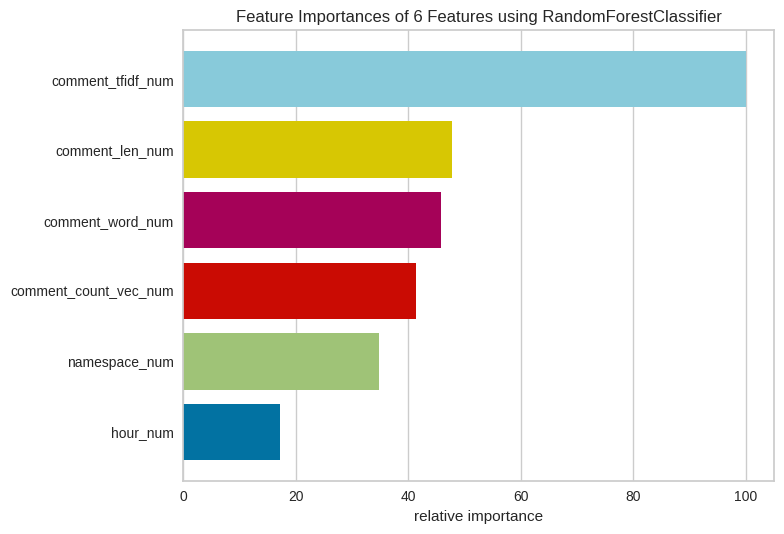

<Axes: title={'center': 'Feature Importances of 6 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [27]:
viz = FeatureImportances(clf)
viz.fit(X_train_wo_user, y_train)
viz.show()

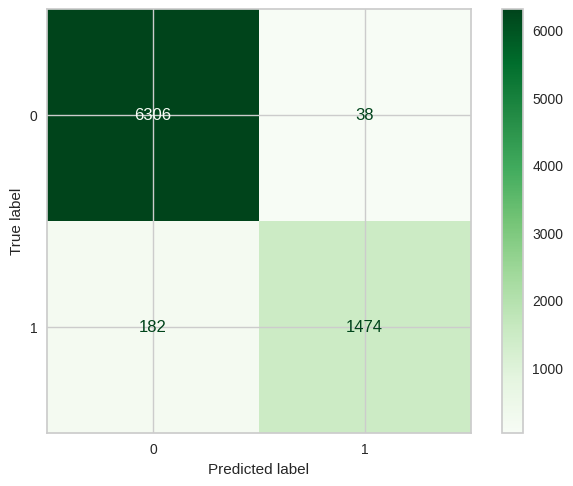

In [28]:
y_pred = clf.predict(X_test_wo_user)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Greens)

In [29]:
misclassified_indices = np.where(y_test != y_pred)[0]
print('Misclassified:', len(misclassified_indices))
FN = np.where((y_test == True) & (y_pred == False))[0]
print('FN:', len(FN))
FP = np.where((y_test == False) & (y_pred == True))[0]
print('FP:', len(FP))


Misclassified: 220
FN: 182
FP: 38


## Finally, train a Bloom Filter that filter out bots from the stream.*
- *Find the correct parameters for the bloom filter having an error around 10%*

Bloom filter is characterized by:
- size of a bit array ($m$)
- number of hash functions

where optimal $m$ can be calculated as:
$$m=-\frac{n*ln(p)}{ln(2)^{2}}$$
,where n is a number of items (bots in our case)\
and number of hash functions as:
$$k=\frac{m}{n}ln(2)$$

So, for the training to start we need to evaluate a number of bots from our sample.

### Definitions

In [30]:
def count_unique_bots(users: Series, labels: Series) -> int:
    """
    Counts the unique bot usernames given user names and their labels.
    
    Args:
        users (Series): A pandas Series containing usernames.
        labels (Series): A pandas Series with True for bot and False for human.
        
    Returns:
        int: The count of unique bot usernames.
    """
    bot_users = users[labels == True]
    unique_bots_count = bot_users.nunique()
    
    return unique_bots_count

In [31]:
def bloom_filter_params(n: int, p: float) -> tuple:
    """
    Calculate bit size (m) and number of hash functions (k) for a Bloom filter.

    Args:
        n (int): Number of items expected to be stored.
        p (float): Desired false positive rate.

    Returns:
        (int, int): Bit size (m) and number of hash functions (k).
    """
    m = np.ceil(-n * np.log(p) / (np.log(2) ** 2))
    k = np.ceil((m / n) * np.log(2))
    
    return m, k

In [32]:
p = 0.1  # 10% error rate

n = count_unique_bots(data['user'], data['bot'])
m, k = bloom_filter_params(n, p)

print(f"for n={n} array size (m) is {m} bits, number of hash functions k is {k}")

for n=68 array size (m) is 326.0 bits, number of hash functions k is 4.0


So, ~350.0 bits array and 3 hash functions are sufficient for the bloom filter in order to remember the population of 73 bots

In [34]:
import hashlib

def hashes(value, num_hashes, size):
    h1 =  int(hashlib.md5(value.encode()).hexdigest(), 16) % size
    h2 =  int(hashlib.sha256(value.encode()).hexdigest(), 16) % size
    if h2 == 0:
        h2 = 1
    return [(h1 + i * h2) % size for i in range(num_hashes)]

class BloomFilter:
    def __init__(self, size: int, hash_count: int):
        self.size = size
        self.hash_count = hash_count
        self.bit_array = [0] * size

    def add(self, item: str):
        for index in hashes(item, self.hash_count, self.size):
            self.bit_array[index] = 1

    def add_all(self, items: list):
        for item in items:
            self.add(item)

    def contains(self, item: str) -> bool:
        for index in hashes(item, self.hash_count, self.size):
            if self.bit_array[index] == 0:
                return False
        return True
    
    def predict(self, data: Series) -> list:
        """
        Predicts values based on data series.

        Args:
        - data (Series): The input data.

        Returns:
        - list: The list of bot predictions.
        """
        predictions = []
        for item in data:
            predictions.append(self.contains(item))
        
        return predictions


In [35]:
def fit_bloom_filter(data: Series, predictions: list, filter: BloomFilter) -> tuple[BloomFilter, list[str]]:
    """
    Fits a Bloom filter with bot usernames based on predictions.

    Args:
    - data (DataFrame): The input data.
    - predictions (list): The list of bot predictions.
    - filter (BloomFilter): The Bloom filter object.

    Returns:
    - tuple[BloomFilter, list[str]]: The fitted Bloom filter object and the list of bot usernames.
    """
    bot_usernames = data[predictions == 1]
    for bot_username in bot_usernames:
        filter.add(bot_username)
    
    return filter, bot_usernames

### Fit & Evaluate Bloom Filter Performance

#### Finding Predictions by means of the Random Forest Classifier on the full dataset

Accuracy: 97.86%


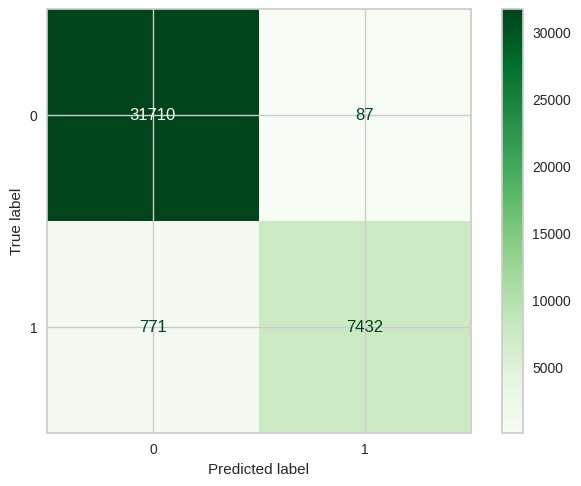

In [36]:
y_pred_full = clf.predict(X.drop(columns=['user']))
print(f"Accuracy: {np.mean(y == y_pred_full)*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y, y_pred_full, cmap=plt.cm.Greens)

In [37]:
print(classification_report(y, y_pred_full))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     31797
           1       0.99      0.91      0.95      8203

    accuracy                           0.98     40000
   macro avg       0.98      0.95      0.97     40000
weighted avg       0.98      0.98      0.98     40000



#### Fitting Random Forest Classifier predictions into Bloom Filter

In [38]:
p = 0.1  # 10% error rate
n = count_unique_bots(data['user'], data['bot'])
m, k = bloom_filter_params(n, p)

bloom_filter  = BloomFilter(int(m), int(k))
bloom_filter, bot_usernames = fit_bloom_filter(X['user'], y_pred_full, bloom_filter)

#### Evaluating the performance of the Bloom Filter on the full dataset

Accuracy: 57.81%


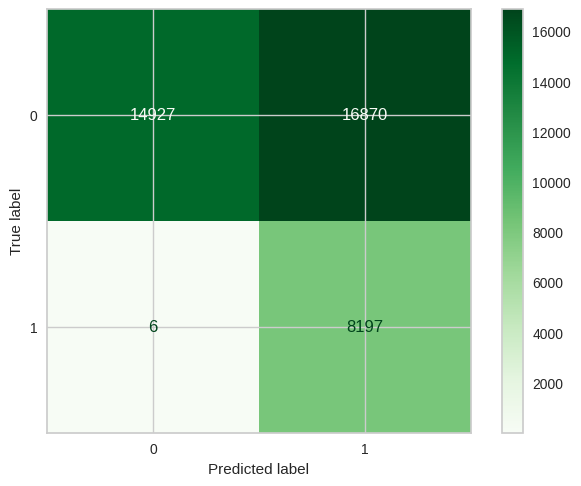

In [39]:
y_pred_bf = bloom_filter.predict(X['user'])
print(f"Accuracy: {np.mean(y == y_pred_bf)*100:.2f}%")
ConfusionMatrixDisplay.from_predictions(y, y_pred_bf, cmap=plt.cm.Greens)    

In [40]:
print(classification_report(y, y_pred_bf))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64     31797
           1       0.33      1.00      0.49      8203

    accuracy                           0.58     40000
   macro avg       0.66      0.73      0.57     40000
weighted avg       0.86      0.58      0.61     40000



Despite the Bloom Filter being configured to allow an approximate 10% error (due to its bit array size), combined with the prediction errors introduced by the Random Forest Classifier, the significant advantage of the Bloom Filter lies in its ability to minimize False Negatives. This is likely the primary purpose of the filter.

Also, the True Positive rate saw a notable improvement, resulting in an increase in overall recall from 91% to 99%. This enhancement reflects the filter strength in ensuring high sensitivity.

However, this improvement comes at the cost of an increased rate of False Positives. This is a known and expected trade-off when using a Bloom Filter. Nevertheless, these False Positives can be mitigated or managed through subsequent processing steps, ensuring that the benefits outweigh the drawbacks in the broader application.

## Spark Streaming

TBD

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, udf
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, LongType
import os
from threading import Thread
import time

ITEM_LIMIT = 40000
processed_count = spark.sparkContext.accumulator(0)  # Accumulator to track processed count

# Define event schema
event_schema = StructType([
    StructField("type", StringType(), True),
    StructField("wiki", StringType(), True),
    StructField("bot", BooleanType(), True),
    StructField("user", StringType(), True),
    StructField("timestamp", LongType(), True),
    StructField("namespace", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("comment", StringType(), True),
    StructField("length", StructType([
        StructField("old", IntegerType(), True),
        StructField("new", IntegerType(), True)
    ])),
    StructField("revision", StructType([
        StructField("old", StringType(), True),
        StructField("new", StringType(), True)
    ])),
    StructField("id", StringType(), True)
])

# Define UDFs
def is_relevant_event_udf(wiki: str):
    def is_relevant_event(event_type: str, event_wiki: str) -> bool:
        return event_type == "edit" and event_wiki == wiki
    return udf(is_relevant_event, BooleanType())

def should_sample_event_udf(sample_by: str, threshold: float = 0.2):
    def should_sample_event(value: str) -> bool:
        if not value:
            return False
        time_hash_val = abs(hash(value)) % 100 / 100
        return time_hash_val < threshold
    return udf(should_sample_event, BooleanType())

# Custom function to append each batch to a single CSV file
def write_to_single_csv(batch_df: DataFrame, batch_id: int):
    global processed_count
    
    # Count items in the current batch
    batch_count = batch_df.count()
    
    # Update the global processed count
    processed_count.add(batch_count)
    
    pdf = batch_df.toPandas()
    csv_file = "./work/sampled_events_id_spark.csv"
    pdf.to_csv(csv_file, mode='a', header=not os.path.exists(csv_file), index=False)

    # Check if the limit has been reached
    if processed_count.value >= ITEM_LIMIT:
        print(f"Limit of {ITEM_LIMIT} items reached. Stopping query.")
        for active_query in spark.streams.active:
            active_query.stop()


# Initialize Spark session
spark = SparkSession.builder \
    .appName("WikiEditSampler") \
    .getOrCreate()

# Read streaming data from the socket
input_stream = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9991) \
    .load()

# Parse JSON data
parsed_stream = input_stream \
    .selectExpr("CAST(value AS STRING) AS json_data") \
    .select(from_json(col("json_data"), event_schema).alias("data")) \
    .select("data.*")

# Apply filters and sampling logic
relevant_stream = parsed_stream \
    .filter(is_relevant_event_udf("enwiki")(col("type"), col("wiki"))) \
    .filter(should_sample_event_udf("id", 0.2)(col("id")))

# Write the sampled events to CSV
query = relevant_stream.select(
    col("bot"), col("user"), col("timestamp"), col("namespace"),
    col("title"), col("comment"), col("length.old").alias("length_old"),
    col("length.new").alias("length_new"), col("revision.old").alias("revision_old"),
    col("revision.new").alias("revision_new")
).writeStream \
    .foreachBatch(write_to_single_csv) \
    .outputMode("append") \
    .start()

def show_progress(query):
    global processed_count

    while query.isActive:
        if query.lastProgress:
            print(f"\nProcessed {processed_count} items")            
        time.sleep(5)  # Adjust interval as needed

# Run the progress display in a separate thread
progress_thread = Thread(target=show_progress, args=(query,), daemon=True)
progress_thread.start()

# Await termination
query.awaitTermination()
